# Groupe non officiel 1
# Livrable 2 - Traitement d'images

|Auteur|Centre|
|---|---|
|ACQUART Quentin|Aix-en-Provence|
|DIMEGLIO Nicolas|Aix-en-Provence|
|ROMANO Sébastien|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

## Rappel du sujet
L'entreprise voulant automatiser la sélection de photos pour l'annotations, le but est de fournir une méthode de classification binaire à fin de filtrer les images qui ne sont pas des photos du dataset de départ. Pour ce faire nous allons nous appuyer sur l'architecture des réseaux de neurones, ainsi que l'analyse des résultats obtenus.
Toutes les parties doivent être détaillées dans le notebook :
    - les paramètre du réseau,
    - la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

## Analyse à effectuer

Le but de cette étape va être le suivant :
    Traiter l'ensemble des photographies via un bruitage puis un débruitage à fin d'améliorer leur qualité.
    Le tout à l'aide d'un auto-encodeur à convolution.


## Import des différentes bibliothèques

In [2]:
import pathlib
import zipfile
import os
import tensorflow as tf
from PIL import Image as Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import random
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn.model_selection import train_test_split

## Téléchargement des données et dezippage
Pour cette partie se referrer au notebook [Préparation des données](Préparation_des_données.ipynb#section_1)
## Récupération des données
Une fois les datasets mis en place, sélectionner le dataset à utiliser dans la variable `data_dir`

In [3]:
clean_dataset = "../DatasetL2/Project_Dataset_Unzip"

data_dir = clean_dataset

data_dir = pathlib.Path(data_dir)

In [4]:
image_h = 180
image_w = 180
batch_s = 32

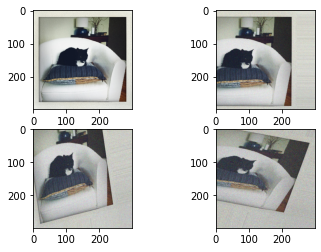

In [82]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [23]:
def add_noise(img):
    noise_factor = 0.9
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    img = img + noise
    np.clip(img, 0., 1.)
    return img

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        preprocessing_function=add_noise,
        )

train_generator = train_datagen.flow_from_directory(
        clean_dataset,
        target_size=(150, 150),
        batch_size=32,
        class_mode=None,
        )

#validation_generator = test_datagen.flow_from_directory(
#        'clean_dataset',
#        target_size=(150, 150),
#        batch_size=32,
#        class_mode='binary')

Found 150 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


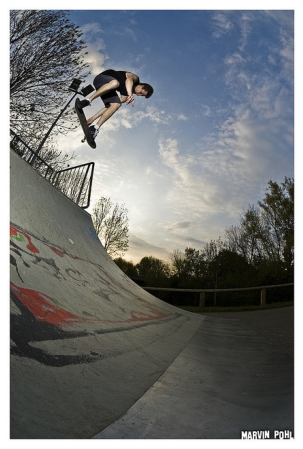

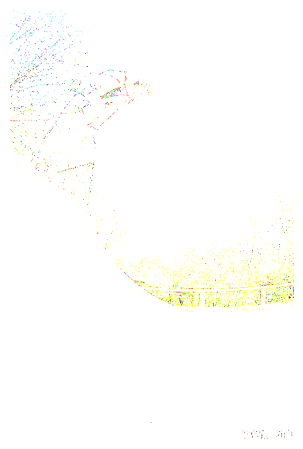

In [39]:
from keras.preprocessing import image
def display_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def noisy(img):
    noise_factor = 0.5
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    img = img + noise
    np.clip(img, 0., 1.)
    return img

img = image.load_img('../DatasetL2/Project_Dataset_Unzip/Dataset/noisy_139.jpg')  # this is a PIL image
display_image(img)
img = noisy(image.img_to_array(img))
display_image(img)

In [18]:
from keras.preprocessing import image
img = image.load_img('../DatasetL2/Project_Dataset_Unzip/Dataset/noisy_139.jpg')  # this is a PIL image
x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='../preview', save_prefix='image_noisy', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [15]:
#from keras.preprocessing import image
#img_dir_path = "..\DatasetL2\Project_Dataset_Unzip\Dataset"
#for file in os.listdir(img_dir_path):
#    img = image.load_img(img_dir_path + "/" + file, target_size=(180,180))

#images = [img]
#img_arr = image.img_to_array(img)
#for batch in train_datagen.flow(img_arr, batch_size=32):
#    images.append( image.array_to_img(batch[0]) )


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (180, 180, 3))

[[[-0.05342073 -0.09532242  0.40525403]
  [-0.12741649  0.0843852   0.88891821]
  [-1.74652396  0.13630034 -0.72129125]
  ...
  [-0.09340884 -0.3005169  -1.002902  ]
  [ 0.28965079  0.54458817 -1.09760712]
  [ 0.09799972 -0.30010682  0.99449435]]

 [[ 0.86416839 -0.73407271  0.68183453]
  [-0.0218729   0.86087899 -0.01667465]
  [-0.1050031   0.51162503  0.28979713]
  ...
  [ 0.38903392 -0.7528024  -0.06932653]
  [ 0.33718334  0.28456239  0.47616128]
  [ 0.11032447 -0.10239707  0.99295652]]

 [[-0.37175861  0.6099181   0.01036041]
  [-0.20401945  0.15631845 -0.39982025]
  [ 0.40343064 -0.33979084 -0.10487425]
  ...
  [ 0.05620441  0.64040644 -0.8022146 ]
  [ 0.18002582  0.80355887  0.05882418]
  [-0.34990802 -0.93334353  0.42099703]]

 ...

 [[ 0.07708735 -0.29371032  0.03293978]
  [-0.0287357   0.52601811  0.15436554]
  [-0.20109285  0.06602881  0.00477509]
  ...
  [-0.61022576 -0.05906436 -0.43470104]
  [ 0.54747041  0.00486141 -0.4258542 ]
  [ 0.26380672  0.09934845  0.13579788]]

 [

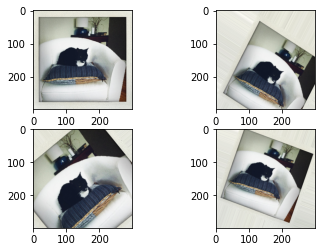

In [104]:
def display_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    noise_factor = 0.5
    deviation = VARIABILITY*random.random()
    #noise = np.random.normal(0, deviation, img.shape)
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    img = img + noise
    np.clip(img, 0., 1.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )

# Load a single image as our example
from keras.preprocessing import image
img_dir_path = "..\DatasetL2\Project_Dataset_Unzip\Dataset"
for file in os.listdir(img_dir_path):
    img = image.load_img(img_dir_path + "/" + file, target_size=(299,299))

# Generate distorted images
images = [img]
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)
for batch in datagen.flow(img_arr, batch_size=1):
    images.append( image.array_to_img(batch[0]) )
    if len(images) >= 4:
        break

f, xyarr = plt.subplots(2,2)
xyarr[0,0].imshow(images[0])
xyarr[0,1].imshow(images[1])
xyarr[1,0].imshow(images[2])
xyarr[1,1].imshow(images[3])
plt.show()

In [65]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode=None,
  labels=None
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode=None,
  labels=None
)

Found 150 files belonging to 1 classes.
Using 120 files for training.
Found 150 files belonging to 1 classes.
Using 30 files for validation.


In [66]:
images = next(iter(train_set))
print(images.shape)

(32, 180, 180, 3)


In [67]:
encoding_dim = 32

input_img = keras.Input(shape=(image_h, image_w, 3))

encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

In [71]:
#noise_factor = 0.5
#x_train_noisy = train_set + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_set.shape)

#x_test_noisy = test_set + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_set.shape)

#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

AttributeError: 'BatchDataset' object has no attribute 'shape'

In [68]:
from keras import regularizers

input_img = keras.Input(shape=(image_h, image_w, 3))
encoded = layers.Dense(128, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)

In [69]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

autoencoder.fit(train_set,
                epochs=10,
                batch_size=batch_s,
                shuffle=True,
                validation_data=test_set,
                )

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
dense_50 (Dense)             (None, 180, 180, 128)     512       
_________________________________________________________________
dense_51 (Dense)             (None, 180, 180, 64)      8256      
_________________________________________________________________
dense_52 (Dense)             (None, 180, 180, 32)      2080      
_________________________________________________________________
dense_53 (Dense)             (None, 180, 180, 64)      2112      
_________________________________________________________________
dense_54 (Dense)             (None, 180, 180, 128)     8320      
_________________________________________________________________
dense_55 (Dense)             (None, 180, 180, 784)     101

In [70]:
encoded_imgs = encoder.predict(test_set)
decoded_imgs = decoder.predict(encoded_imgs)

ValueError: in user code:

    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    d:\pycharmprojects\pythoninovproject\venv\lib\site-packages\keras\engine\input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_39: expected shape=(None, 32), found shape=(None, 180, 180, 32)
